## MSDS 7331 Data Mining: Regression & SVM

***  

Team: Andrew Abbott, Vivek Bejugama, Patrick McDevitt, Preeti Swaminathan



***
	
We are using online news popularity dataset from UCI machine learning repository. The dataset is a collection of 61 heterogeneous set of features of approximately 40,000 articles published by Mashable (www.mashable.com) - the features are not the articles, but features extracted from the article, such as word counts, title word counts, keyword associations.  The data represents a two year period of published articles, ending in January 2015.  

We intend to mine this data to understand what parameters can influence an article to be shared on social media more than others.  The goal is to predict the number of shares in social networks (popularity).  

The business use of this data set / data mining project is ultimately to establish relationships that enable to predict how many social media shares an article published on _www.mashable.com_ is likley to generate - with the idea that a more socially shared article has higher business value - increasing traffic to the site, and consequently, potential for higher earnings revenue associated to the increased web traffic. The user of this model is both the publishers for _mashable.com_ for article selection, and also for authors, attempting to create content that has higher value on sites like _mashable.com_.  

Measures for a successful outcome from a predictive model for this study will be based on overall accuracy metrics (e.g., confusion matrix), as well as AUC type metrics. A baseline (non-predictive, random) scoring will establish a baseline for these metrics, and then the predictive model can be assessed against a random model for measurement of improvement, i.e., value of the model.  

The data is located at https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity  

***  
__Citation Request__ :  
***  
K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal.  
***  


- The data set has features in these 6 broad categories :  
_(ref - see citation reference at beginning of this document)_  
    - Words  
        - Number of words of the title/content  
        - Average word length  
        - Rate of unique/non-stop words of contents
    - Links
        - Number of links  
        - Number of links to other articles in Mashable  
    - Digital Media  
        - Number of images/videos  
    -Time  
        - Day of the week/weekend  
    - Keywords  
        - Number of keywords  
        - Worst/best/average keywords (#shares)  
        - Article category  
    - NLP  
        - Closeness to five LDA topics  
        - Title/Text polarity/subjectivity  
        - Rate and polarity of positive/negative words  
        - Absolute subjectivity/polarity level  
     



In [70]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  - Revisions

# ...  2017.09.28
# ...  - general rewrite of data cleaning / create input data set for models
# ...  - added first set of SVM models
# ...
# ...  2017.10.01
# ...  - added additional metrics (precision, recall, F1) to SVM model outputs
# ...  - updated KDE plots to top weighted support vectors from linear SMV model
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=



### __Grading Rubric__  


#### __Create Models (50)__    

* Create a logistic regression model and a support vector machine model for the classification task involved with your dataset.  
* Assess how well each model performs (use 80/20 training/testing split for your data).  
* Adjust parameters of the models to make them more accurate.  
* If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines.  
* For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe.   


#### __Model Advantages (10)__  

* Discuss the advantages of each model for each classification task.  
* Does one type of model offer superior performance over another in terms of prediction accuracy?  
* In terms of training time or efficiency?  
* Explain in detail.  

#### __Interpret Feature Importance (30)__  

* Use the weights from logistic regression to interpret the importance of different features for the classification task.  
* Explain your interpretation in detail.  
* Why do you think some variables are more important?  


#### __Interpret Support Vectors (10)__  

* Look at the chosen support vectors for the classification task.  
* Do these provide any insight into the data? Explain.  
* If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model — then analyze the support vectors from the subsampled dataset.  



In [71]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#...  Import Required Packages
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore',DeprecationWarning)

import seaborn as sns


import time


In [72]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  Import Data from .csv file
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... change directory as needed to point to local data file 
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

data_dir = '../data/'
data_file = 'OnlineNewsPopularity.csv'

file_2_read = data_dir + data_file

df = pd.read_csv(file_2_read)  


# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  Strip leading spaces and store all the column names to a list
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df.columns = df.columns.str.strip()

col_names = df.columns.values.tolist()




In [73]:
# Summary of attributes
df.info()

df.describe().T

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... drop a few columns just based on inspection
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# ...  these 2 columns are all zeros except for 1 data point

del df['n_non_stop_words']
del df['n_non_stop_unique_tokens']
del df['n_unique_tokens']


# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... make some decisions about what to do with these ...
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# ... average_token_length has a high number of zeros .. is this OK or do they want to be imputed ?
# ... average_negative_polarity has population of zeros ... OK or impute ?
# ... average postivie polarity ... same as above
# ... global_rate_postive_words ... same as above
# ... global_subjectivity ... same as above
# ... kw_min_avg ... same as above
# ... kw_min_min ... weird data ... maybe just delete ?



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
url                              39644 non-null object
timedelta                        39644 non-null float64
n_tokens_title                   39644 non-null float64
n_tokens_content                 39644 non-null float64
n_unique_tokens                  39644 non-null float64
n_non_stop_words                 39644 non-null float64
n_non_stop_unique_tokens         39644 non-null float64
num_hrefs                        39644 non-null float64
num_self_hrefs                   39644 non-null float64
num_imgs                         39644 non-null float64
num_videos                       39644 non-null float64
average_token_length             39644 non-null float64
num_keywords                     39644 non-null float64
data_channel_is_lifestyle        39644 non-null float64
data_channel_is_entertainment    39644 non-null float64
data_channel_is_bus              39644 non-null floa

In [74]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  convert the data type to Integer
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

to_int = ['timedelta','n_tokens_title', 'n_tokens_content',
    'num_hrefs','num_self_hrefs', 'num_imgs', 'num_videos', 'num_keywords',
    'data_channel_is_lifestyle',
    'data_channel_is_entertainment',
    'data_channel_is_bus',
    'data_channel_is_socmed',
    'data_channel_is_tech',
    'data_channel_is_world',
    'weekday_is_monday',
    'weekday_is_tuesday',
    'weekday_is_wednesday',
    'weekday_is_thursday',
    'weekday_is_friday',
    'weekday_is_saturday',
    'weekday_is_sunday',
    'is_weekend',
    'shares']

df[to_int] = df[to_int ].astype(np.int64)

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  check for duplicates
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df[df.duplicated()]


,url,timedelta,n_tokens_title,n_tokens_content,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares


#### Create new features from existing data set  

- Based on inspection of the data set, we ideitified several opportunities to create some useful features from the original data set.

- The first data field, _url_, is the url address of the mashable published article, which contains in the link the year, month, day that the article was published and also the article title. We will use a string splitting function to parse the information in the url address to create the additional data columns : _year_, _month_, _day_, and _title_. Further, we can then combine the parsed year, month, day into a _published_date_ column. Although the original data set does contain the field _timedelta_ which provdes essentially a timeline of article publication dates, it does not contain the actual date of publication. We consider that having the actual date may prove useful to provide context or linkage with external data sources. We are not, at this time, linking in any additional external data sources, but that may be an opportunity with future work. In addition, we consider to storethe _title_ as a distinct data column, but we are not performing any analysis on that field at this time. We consider that the article title is an opportunity for text mining in the classification problem to be evaluated also with future work.  

- The data fields : _is_entertainment_, _is_lifestyle_, ... are each boolean indicators of the type of data channel associated to the published article. Since these are mutually exclusive binary indicators, we can combine into one common feature, _data_channel_, to condense the information of those 6 columns into one column. This provides some reduction in complexity of the data set, and also provides opportunity to more easily make comparison plots for the relative popularity of these data channels.  

- Similar to the _data_channel_ column, there is also a set of columns : _is_monday_, _is_tuesday_, ... which are also a set of mutually exclusive binary indicators. Using the same logic as above, we combine those values into a single column _day_of_week_. There is an additional column _is_weekend_ which we retain for now, as that provides opportunity to evaluate if weekend responses are different than weekday responses.  

- And finally, we also created a column to be used as binary popularity measure. Based on the business description of the goal, the goal is to build a model that provides predictive capability of article 'popular' or 'not popular', based on the metric of number of shares > 1400 (popular) or number of shares < 1400 (not popular). The value of 1400 was provided in the business statement, and is also the median value of the number of shares in the experience of this data set. To accomplish that purpose, we create a new column (binary) _popularity_ which is based on the number of shares reported in the _shares_ data column. This can be used in future work, e.g., in classificiation or binary logistic regression analyses to support the business goal.  

- The code to accomplish all of the above is shown here below.  

***  


In [75]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... Extract useable elements from the string URL
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df['http'], df['blank'], df['mash'], df['year'], df['month'], df['day'],df['title'],df['extra'] = df['url'].str.split('\/', 7).str

# ...  delete unneeded columns

del df['http'], df['blank'], df['mash'], df['extra']
del df['url']
del df['title']

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  Derive date column from year-month-day fields
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df['year']  = (df['year']).astype(str)
df['month'] = (df['month']).astype(str)
df['day']   = (df['day']).astype(str)
df['publish_date'] = pd.to_datetime(df.year + df.month + df.day, format = "%Y%m%d")

del df['month']
del df['day']

df['year'] = df['year'].astype(int)

del df['publish_date'] ## ... remove for SVM data set ... add back in for timeline plots



In [76]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  ln() transform right skewed distribution variables (skewness > 1)
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_numeric = df.select_dtypes(['number'])

numeric_col_names = df_numeric.columns.values.tolist()

# ... store min value for each column

df_mins = df.min()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  loop on each column, test for skewness, create new column if conditions met
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

columns_to_drop = []

for column in numeric_col_names:
    sk = df[column].skew()
    
    if(sk > 1):
        new_col_name = 'ln_' + column
        print (column, sk, new_col_name)
        
        if df_mins[column] > 0:
            df[new_col_name] = np.log(df[column])
            columns_to_drop.append(column)
            
        elif df_mins[column] == 0:
            df_tmp = df[column] + 1
            df[new_col_name] = np.log(df_tmp)
            columns_to_drop.append(column)
            
        else:
            print('--> Ln() transform not completed -- skew > 1, but min value < 0 :', column, '!!')
            
            
# ... delete tmp data

del df_tmp
del df_mins
del df_numeric

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  based on inspection, a few of these are just not valid ranges in ln() space
# ...  -- just delete these few back out of the data set
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

print (columns_to_drop)



del df['ln_LDA_00']
del df['ln_LDA_01']
del df['ln_LDA_02']
del df['ln_LDA_03']
del df['ln_LDA_04']
columns_to_drop.remove('LDA_00')
columns_to_drop.remove('LDA_01')
columns_to_drop.remove('LDA_02')
columns_to_drop.remove('LDA_03')
columns_to_drop.remove('LDA_04')


# ...  these are binary indicators ... so no need to ln-transform

del df['ln_data_channel_is_lifestyle']
del df['ln_data_channel_is_entertainment']
del df['ln_data_channel_is_bus']
del df['ln_data_channel_is_socmed']
del df['ln_data_channel_is_tech']
del df['ln_data_channel_is_world']
del df['ln_weekday_is_monday']
del df['ln_weekday_is_tuesday']
del df['ln_weekday_is_wednesday']
del df['ln_weekday_is_thursday']
del df['ln_weekday_is_friday']
del df['ln_weekday_is_saturday']
del df['ln_weekday_is_sunday']

del df['ln_is_weekend']
columns_to_drop.remove('is_weekend')

columns_to_drop.remove('data_channel_is_lifestyle')
columns_to_drop.remove('data_channel_is_entertainment')
columns_to_drop.remove('data_channel_is_bus')
columns_to_drop.remove('data_channel_is_socmed')
columns_to_drop.remove('data_channel_is_tech')
columns_to_drop.remove('data_channel_is_world')
columns_to_drop.remove('weekday_is_monday')
columns_to_drop.remove('weekday_is_tuesday')
columns_to_drop.remove('weekday_is_wednesday')
columns_to_drop.remove('weekday_is_thursday')
columns_to_drop.remove('weekday_is_friday')
columns_to_drop.remove('weekday_is_saturday')
columns_to_drop.remove('weekday_is_sunday')


# ... not needed for binary analysis ... will use popular indicator

del df['ln_shares'] 
columns_to_drop.remove('shares')

print ('\n-----------------------------------\n')
print ('Number of current columns in dataset :', len(df.columns))



df.drop(columns_to_drop, axis = 1, inplace = True)

df.info()


n_tokens_content 2.94542193879 ln_n_tokens_content
num_hrefs 4.0134948282 ln_num_hrefs
num_self_hrefs 5.17275110576 ln_num_self_hrefs
num_imgs 3.94659584465 ln_num_imgs
num_videos 7.0195327863 ln_num_videos
data_channel_is_lifestyle 3.99301914336 ln_data_channel_is_lifestyle
data_channel_is_entertainment 1.6835848094 ln_data_channel_is_entertainment
data_channel_is_bus 1.87687018599 ln_data_channel_is_bus
data_channel_is_socmed 3.75887963097 ln_data_channel_is_socmed
data_channel_is_tech 1.61997576469 ln_data_channel_is_tech
data_channel_is_world 1.40516938412 ln_data_channel_is_world
kw_min_min 2.37494728018 ln_kw_min_min
--> Ln() transform not completed -- skew > 1, but min value < 0 : kw_min_min !!
kw_max_min 35.3284337312 ln_kw_max_min
kw_avg_min 31.3061081027 ln_kw_avg_min
--> Ln() transform not completed -- skew > 1, but min value < 0 : kw_avg_min !!
kw_min_max 10.3863716348 ln_kw_min_max
kw_max_avg 16.4116695554 ln_kw_max_avg
kw_avg_avg 5.76017729162 ln_kw_avg_avg
self_reference

#### Data Selection - First evaluation  

- There are 60 columns in the original data set; we added a few additonal columns based on observed opportunities (e.g., _publication_date_, ...) as explained above. 
    
- From this data set, we did a simple correlation matrix to look for variables that are highly correlated with each other that could be removed with little loss of information.

- With that downselection, we proceeded with additional evaluation of these remaining variables.
    
- we recognize that there is likely significant additional opportunity for modeling improvements with many of the remaining variables, and will look to re-expand the data set to further consider that with future work.  

In [77]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... display highest correlation pairs from corr() matrix 
# ...
# ... https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_numeric = df.select_dtypes(['number'])

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n = 5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels = labels_to_drop).sort_values(ascending = False)
    return au_corr[0:n]

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... list out Top30 correlations
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

n_val = 30

top_30_corr_list = get_top_abs_correlations(df_numeric, n_val)
print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("Top Absolute Correlations\n")
print(top_30_corr_list)

icor = 0
drop_column = list()
while (top_30_corr_list[icor] > 0.65):
    drop_column.append(top_30_corr_list[top_30_corr_list == top_30_corr_list[icor]].index[0][0])
    icor += 1

drop_column = list(set(drop_column))

print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("Columns Recommended for removal based on correlation > 0.65")
print("-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-\n")

print("\n".join(sorted(drop_column)))

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... drop one of the high correlation columns (2nd of the pair)
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df = df.drop(drop_column, axis = 1)

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... show correlation test with remaining, to confirm
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_reduced_numeric = df.select_dtypes(['number'])

top_30_corr_list = get_top_abs_correlations(df_reduced_numeric, n_val)

print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("\n\nTop Absolute Correlations (2nd Pass)\n")
print(top_30_corr_list)






-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Top Absolute Correlations

ln_self_reference_max_shares   ln_self_reference_avg_sharess      0.994639
ln_self_reference_min_shares   ln_self_reference_avg_sharess      0.971014
                               ln_self_reference_max_shares       0.945943
kw_min_avg                     ln_kw_min_max                      0.926784
ln_kw_max_avg                  ln_kw_avg_avg                      0.899409
timedelta                      year                               0.876403
kw_min_min                     kw_max_max                         0.857226
data_channel_is_world          LDA_02                             0.836618
rate_negative_words            ln_global_rate_negative_words      0.782517
data_channel_is_bus            LDA_00                             0.774651
average_token_length           ln_n_tokens_content                0.768795
data_channel_is_tech           LDA_04                             0.749737
avg_negative_

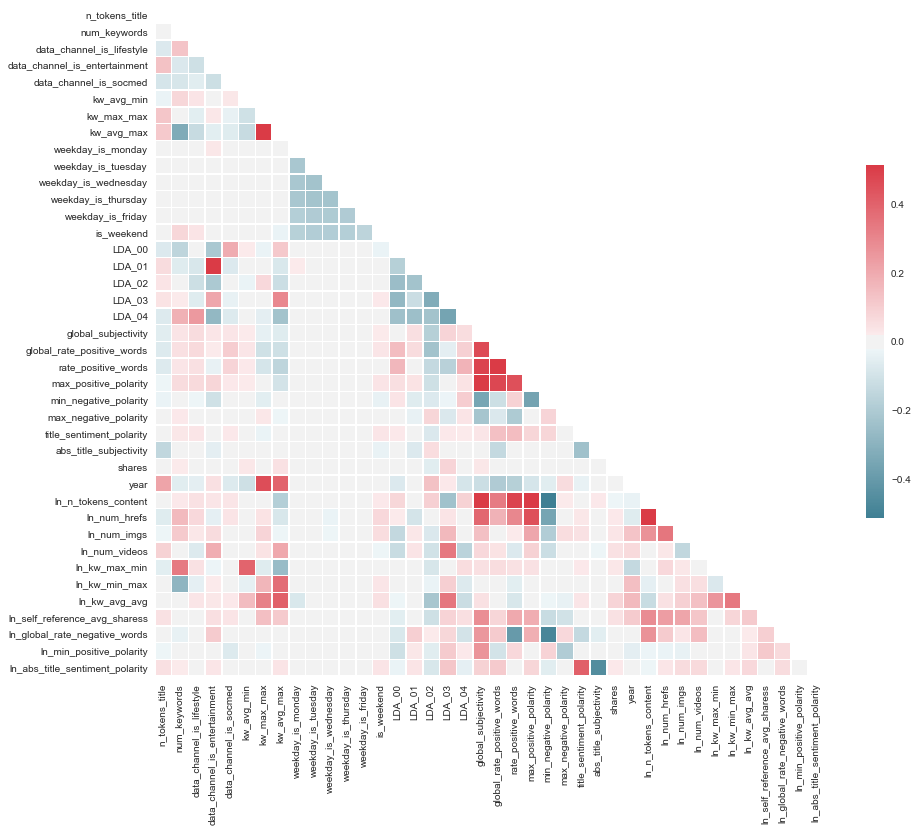

In [78]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


# from example found at https://www.kaggle.com/maheshdadhich/strength-of-visualization-python-visuals-tutorial/notebook

In [79]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... Popularity Variable . Article is considerd popular if it has more than 1400 shares. 
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

popular_binary = np.where(df['shares'] > 1400, True, False)

df.insert(loc = 0, column = 'popular', value = popular_binary)

del df['shares'] 

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 40 columns):
popular                            39644 non-null bool
n_tokens_title                     39644 non-null int64
num_keywords                       39644 non-null int64
data_channel_is_lifestyle          39644 non-null int64
data_channel_is_entertainment      39644 non-null int64
data_channel_is_socmed             39644 non-null int64
kw_avg_min                         39644 non-null float64
kw_max_max                         39644 non-null float64
kw_avg_max                         39644 non-null float64
weekday_is_monday                  39644 non-null int64
weekday_is_tuesday                 39644 non-null int64
weekday_is_wednesday               39644 non-null int64
weekday_is_thursday                39644 non-null int64
weekday_is_friday                  39644 non-null int64
is_weekend                         39644 non-null int64
LDA_00                             39644 non-n

In [80]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  branch a separate copy of data frame to support SVM development
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_svm = df.copy()


data_dir = '../data/'
data_file = 'mashable_clean_dataset_for_LR_and_SVM.csv'

file_2_write = data_dir + data_file

df_svm.to_csv(file_2_write, index = False)

df_svm.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 40 columns):
popular                            39644 non-null bool
n_tokens_title                     39644 non-null int64
num_keywords                       39644 non-null int64
data_channel_is_lifestyle          39644 non-null int64
data_channel_is_entertainment      39644 non-null int64
data_channel_is_socmed             39644 non-null int64
kw_avg_min                         39644 non-null float64
kw_max_max                         39644 non-null float64
kw_avg_max                         39644 non-null float64
weekday_is_monday                  39644 non-null int64
weekday_is_tuesday                 39644 non-null int64
weekday_is_wednesday               39644 non-null int64
weekday_is_thursday                39644 non-null int64
weekday_is_friday                  39644 non-null int64
is_weekend                         39644 non-null int64
LDA_00                             39644 non-n

## Training and Testing Split


For training and testing purposes, we use 80% of the observations for training and 20% for testing. This process is repeated three times and use the hold out cross validation method built into scikit-learn.

In [81]:
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt
from sklearn.svm import SVC

df_svm_top39 = df_svm.copy()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  dataframe in which to record results of model metrics
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

results_table_labels = ['kernel', 'C', 'gamma', 'n_features', 'process_time', 'accuracy', 'recall', 'precision', 'f1_score']
df_results = pd.DataFrame(columns = results_table_labels)

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  separate X and y matrices 
# ...
# ...  convert to numpy matrices by calling 'values' on the pandas data frames
# ...  they are now simple matrices for compatibility with scikit-learn
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

if 'popular' in df_svm_top39:
    y = df_svm_top39['popular'].values         # set 'popular' as dependent
    del df_svm_top39['popular']                # remove from dataset
    X = df_svm_top39.values                    # use everything else for independent EVs

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  setup cross-validation in sklearn
# ...
# ...  split into training and test sets
# ....  --> 3 folds
# ...   --> 80% / 20% training / test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

num_cv_iterations = 3

num_instances = len(y)

cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)



***  

# __Support Vector Machine__  

*** 



In [82]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  run through the cross validation loop and set the training and testing
# ...  variable
# ...
# ...  --> this method is memory-user, but easier to follow what is being done 
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

for train_indices, test_indices in cv_object.split(X, y): 
    X_train = X[train_indices]
    y_train = y[train_indices]    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... scale attributes by the training set
# ... - normalize features based on mean & stdev of each column
# ... - do not use the testing data - this would be snooping
# ... - use what was last stored in the variables: X_train, y_train, X_test, y_test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

    scl_obj = StandardScaler()
    scl_obj.fit(X_train)                        # scale for each column for (0,1) mean, std
    
    X_train_scaled = scl_obj.transform(X_train) # apply to training
    X_test_scaled = scl_obj.transform(X_test)
    
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... use SVM, train the model - start with basic linear model, all features
# ...
# ... - C = 0.5
# ...   - penalty parameter; controls the trade-off between smooth decision boundary
# ...   - and classifying the training points correctly
# ...
# ... - kernel = linear
# ...
# ... - gamma = auto
# ...   - kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’;
# ...   - the higher the value of gamma, will try to exact fit
# ...   - for the rbf kernel the transformed space is infinite-dimensional
# ...
# ...  https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

print('\n----------------------------------------------------')
print('\tSVM - kernel = linear - C = 0.5 - gamma = auto ---')
print('----------------------------------------------------')
 
tic = time.clock()

# ...  get SVC object

krnl = 'linear'
C_param = 0.5
gamma_param = 'auto'

svm_clf = SVC(C = 0.5, kernel = 'linear', degree = 3, gamma = 'auto')

# ... train

svm_clf.fit(X_train_scaled, y_train)

# ... print out process time

toc = time.clock()
    
# ... test set predictions

y_hat = svm_clf.predict(X_test_scaled)

# ... model classification metrics

acc = mt.accuracy_score(y_test, y_hat)
rec = mt.recall_score(y_test, y_hat)
pre = mt.precision_score(y_test, y_hat)
f1s = mt.f1_score(y_test, y_hat)

conf = mt.confusion_matrix(y_test, y_hat)

print('\n----------------------------------------------------')
print('Accuracy  = %9.3f' % acc )
print('Recall    = %9.3f' % rec )
print('Precision = %9.3f' % pre )
print('F1 Score  = %9.3f' % f1s )

print('\n----------------------------------------------------')
print('Confusion matrix\n', conf)
print('----------------------------------------------------')


# ... add model metrics to results data frame

new_row = [krnl, C_param, gamma_param, len(df_svm_top39.columns), toc-tic, acc, rec, pre, f1s]
df_results.loc[len(df_results)] = new_row
print(df_results)




----------------------------------------------------
	SVM - kernel = linear - C = 0.5 - gamma = auto ---
----------------------------------------------------

----------------------------------------------------
Accuracy  =     0.643
Recall    =     0.646
Precision =     0.629
F1 Score  =     0.637

----------------------------------------------------
Confusion matrix
 [[2608 1468]
 [1364 2489]]
----------------------------------------------------
   kernel    C gamma n_features  process_time  accuracy   recall  precision  \
0  linear  0.5  auto         39    260.070015   0.64283  0.64599   0.629012   

   f1_score  
0  0.637388  


In [83]:
# look at the support vectors

print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(25047, 39)
(25047,)
[12524 12523]


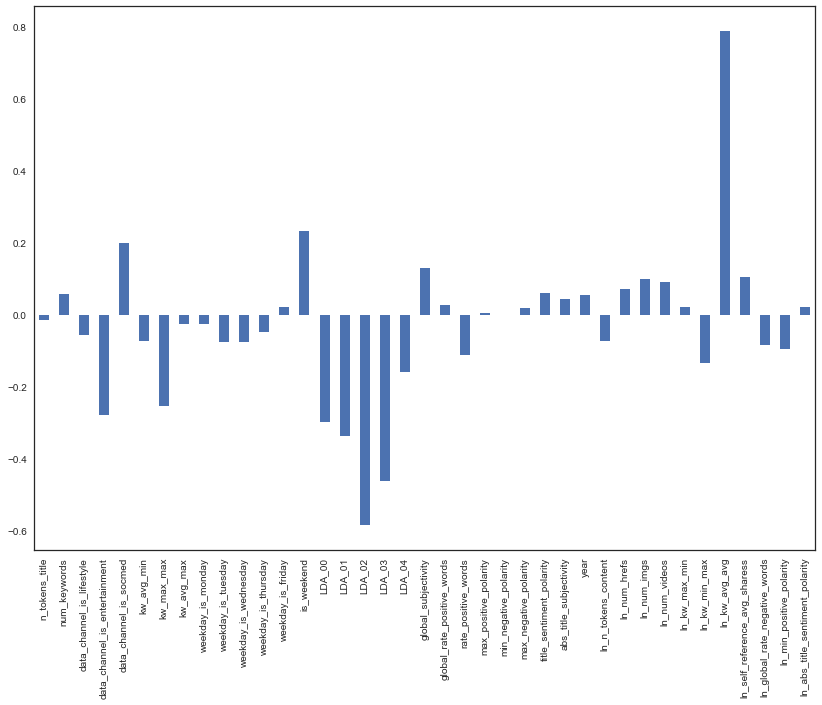

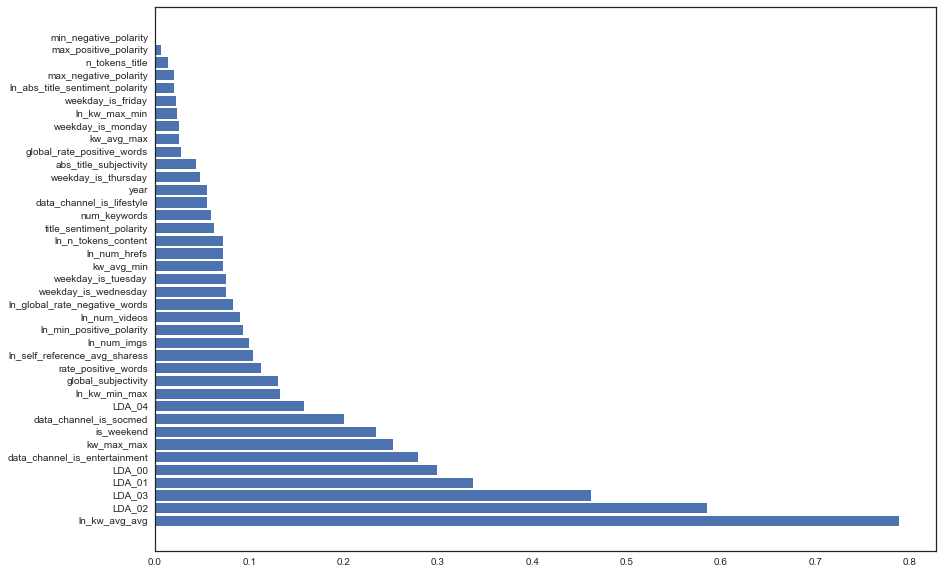

                           ln_kw_avg_avg :     0.788
                                  LDA_02 :     0.585
                                  LDA_03 :     0.462
                                  LDA_01 :     0.337
                                  LDA_00 :     0.299
           data_channel_is_entertainment :     0.278
                              kw_max_max :     0.252
                              is_weekend :     0.234
                  data_channel_is_socmed :     0.200
                                  LDA_04 :     0.158
                           ln_kw_min_max :     0.133
                     global_subjectivity :     0.130
                     rate_positive_words :     0.112
           ln_self_reference_avg_sharess :     0.104
                             ln_num_imgs :     0.099
                ln_min_positive_polarity :     0.094
                           ln_num_videos :     0.091
           ln_global_rate_negative_words :     0.083
                    weekday_is_wednesday :    

In [84]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  support function to create sorted absolute value of SV weights
# ... 
# ...  https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

def f_importances(coef, names):
    imp = coef
    imp_abs = abs(coef)
    imp, names = zip(*sorted(zip(imp_abs,names), reverse = True))
    plt.figure(figsize = (14,10))
    plt.barh(range(len(names)), imp, align = 'center')
    plt.yticks(range(len(names)), names)
    plt.show()
    for nm, val in zip(names, imp):
        print ("%40s : %9.3f" % (nm, val))

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  if kernel = linear -- can plot out the weights to evaluate relative influences
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

krnl = 'linear'

if krnl == 'linear':
#    print(svm_clf.coef_)
#    print(df_svm.columns)

# ... - vertical bar chart with sign retained to see +/- effects

    weights = pd.Series(svm_clf.coef_[0], index = df_svm_top39.columns)
    plt.figure(figsize=(14,10))
    weights.plot(kind = 'bar')

# ... - horizontal bar chart of abs value in ranked order

    f_importances(svm_clf.coef_[0], df_svm_top39.columns)
    

In [85]:
# Review instances chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  review suport vectors for
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


df_tested_on = df_svm_top39.iloc[train_indices] # saved from above, the indices chosen for training

# now get the support vectors from the trained model

df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['popular'] = y[svm_clf.support_] # add back in the 'popular' Column to the pandas dataframe
df_svm_top39['popular'] = y # also add it back in for the original data

df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25047 entries, 31690 to 37558
Data columns (total 40 columns):
n_tokens_title                     25047 non-null int64
num_keywords                       25047 non-null int64
data_channel_is_lifestyle          25047 non-null int64
data_channel_is_entertainment      25047 non-null int64
data_channel_is_socmed             25047 non-null int64
kw_avg_min                         25047 non-null float64
kw_max_max                         25047 non-null float64
kw_avg_max                         25047 non-null float64
weekday_is_monday                  25047 non-null int64
weekday_is_tuesday                 25047 non-null int64
weekday_is_wednesday               25047 non-null int64
weekday_is_thursday                25047 non-null int64
weekday_is_friday                  25047 non-null int64
is_weekend                         25047 non-null int64
LDA_00                             25047 non-null float64
LDA_01                             2504

/home/mcdevitt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


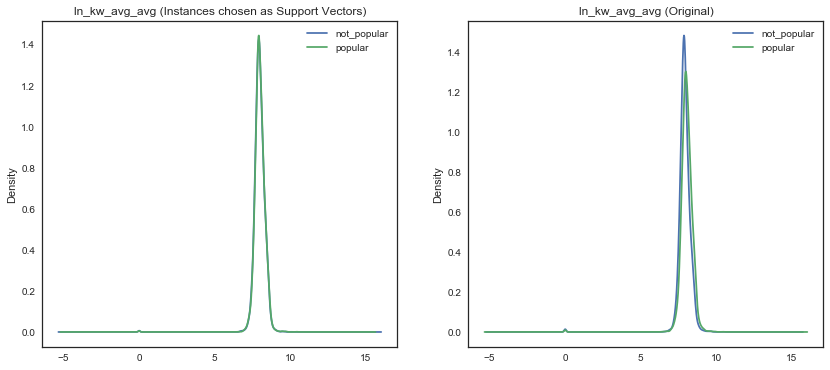

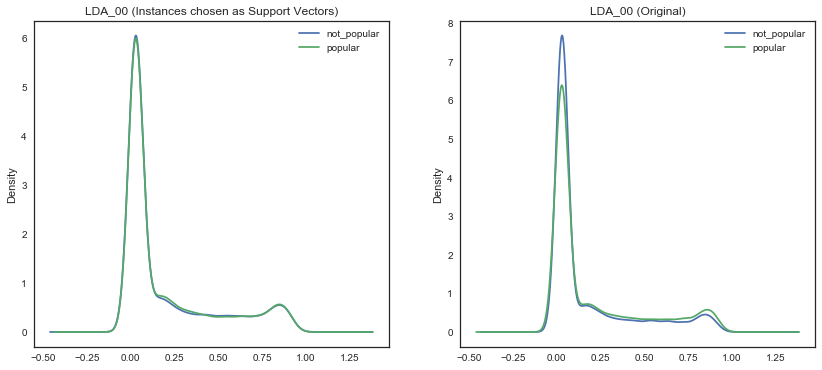

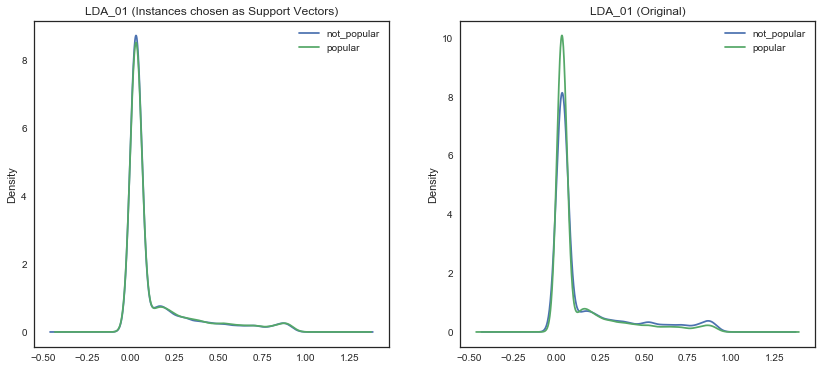

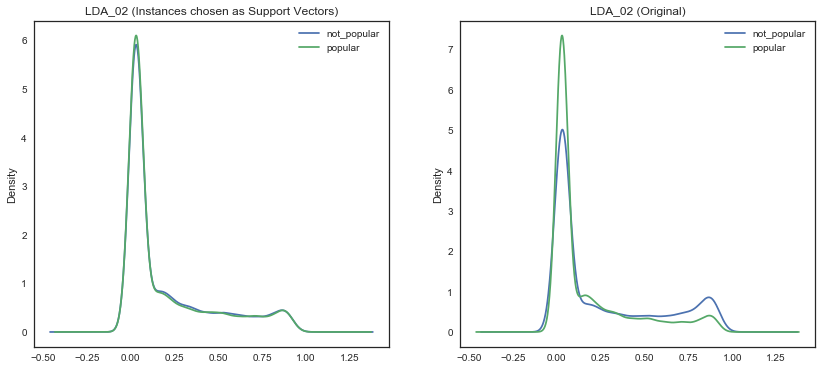

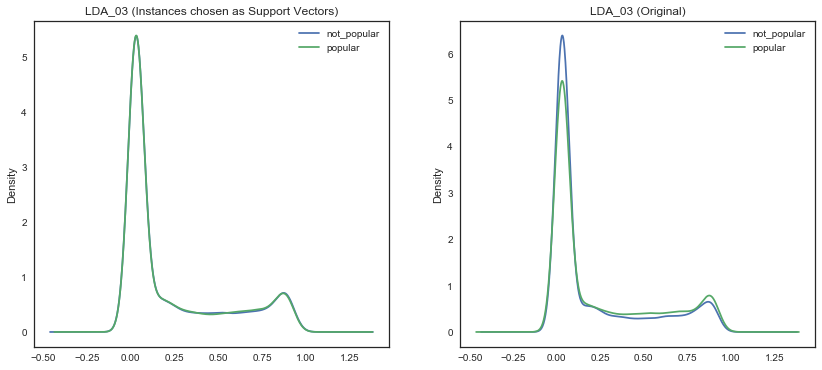

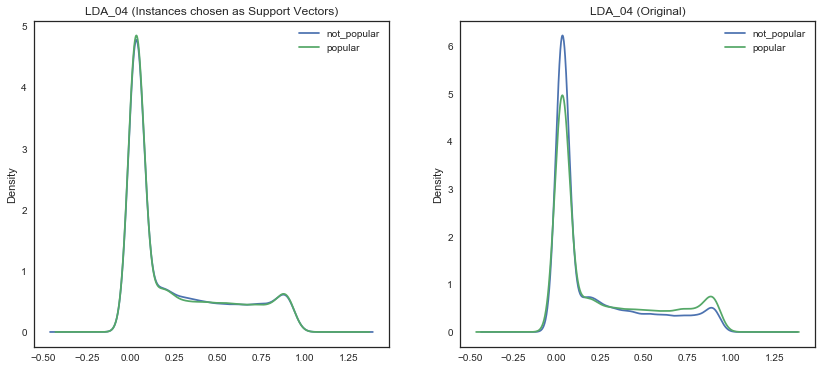

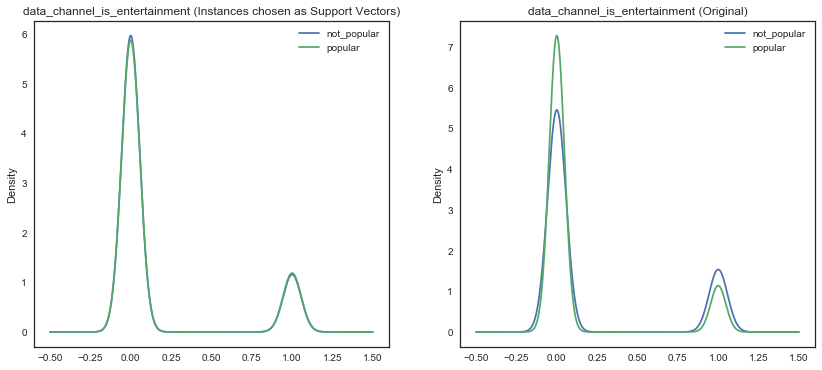

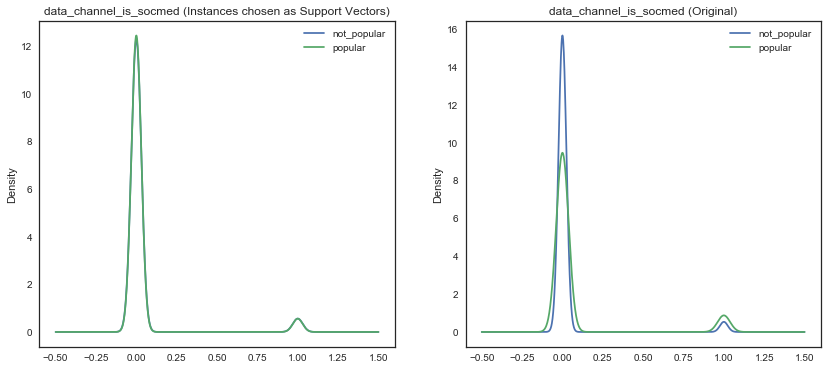

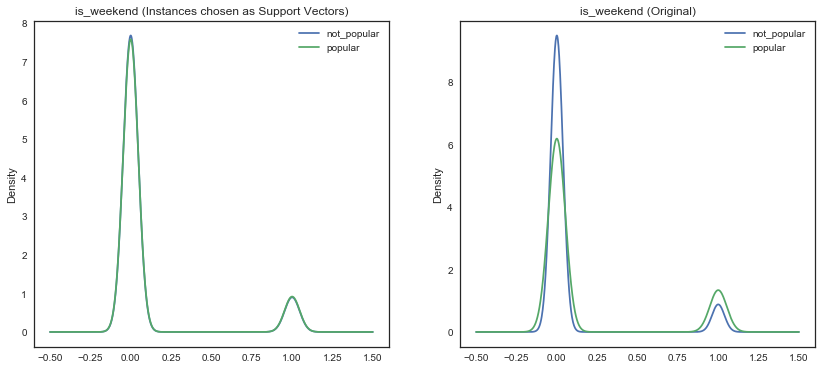

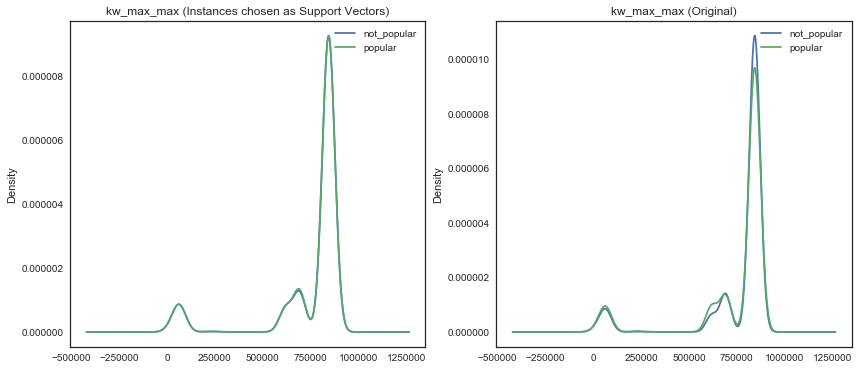

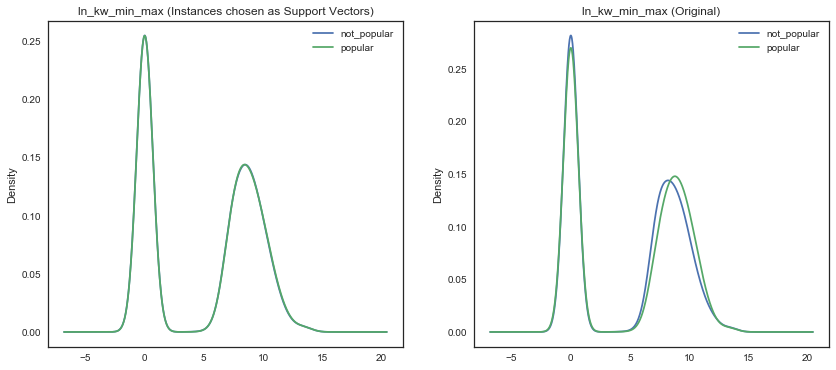

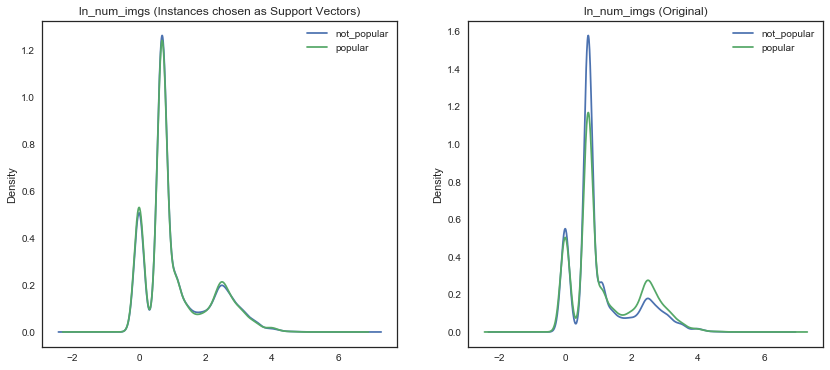

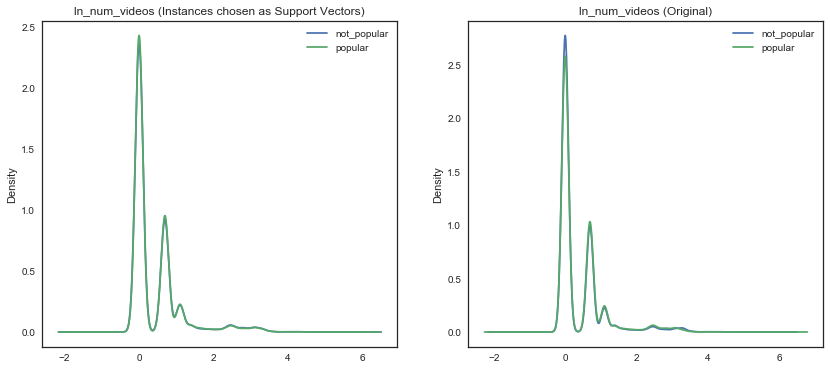

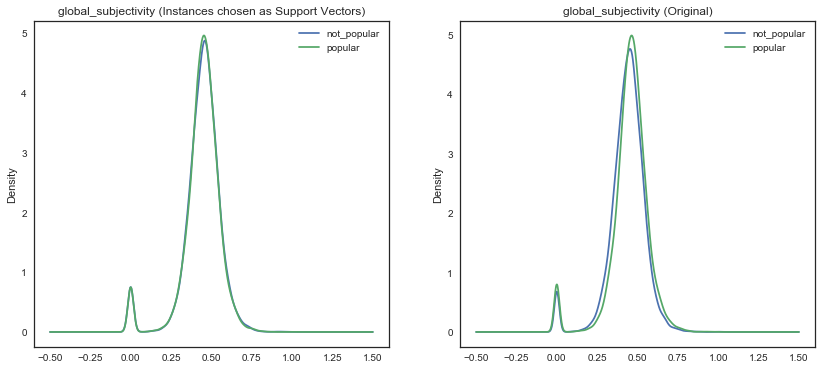

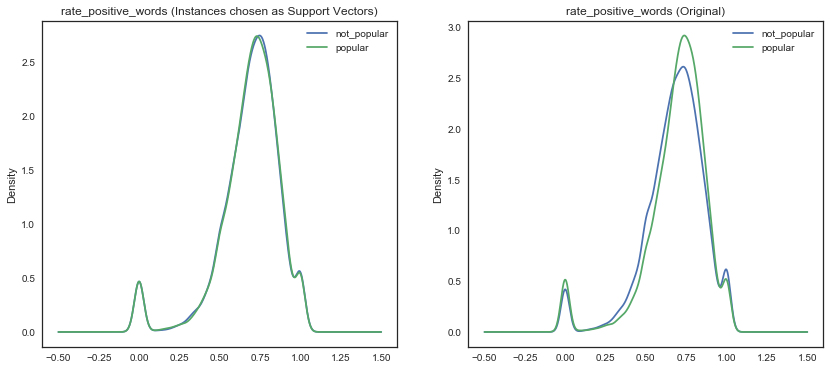

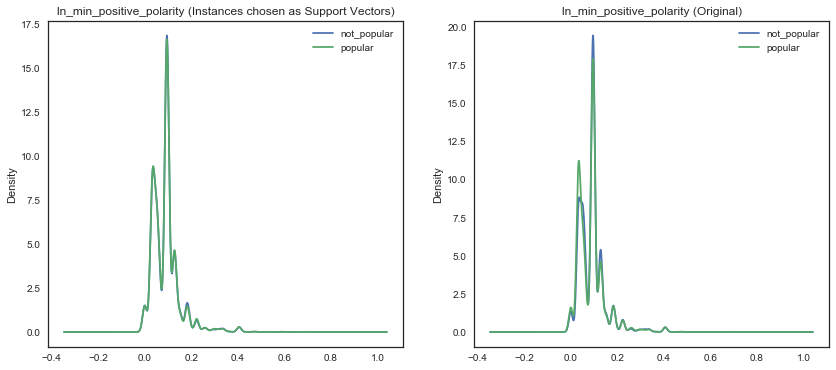

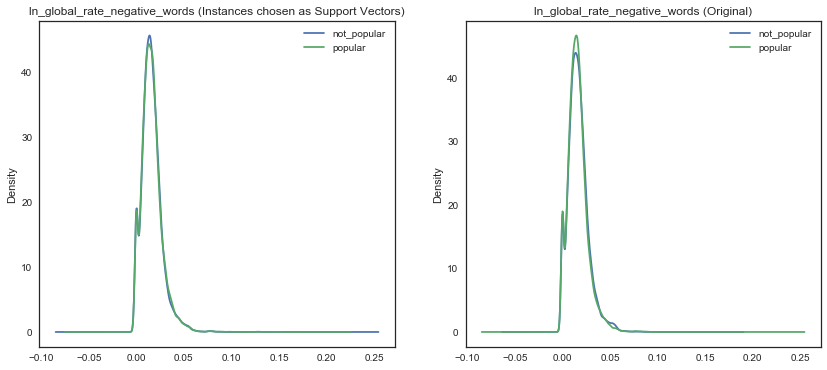

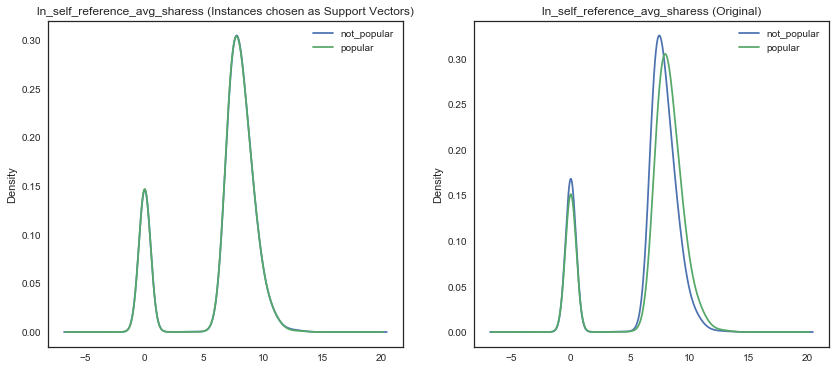

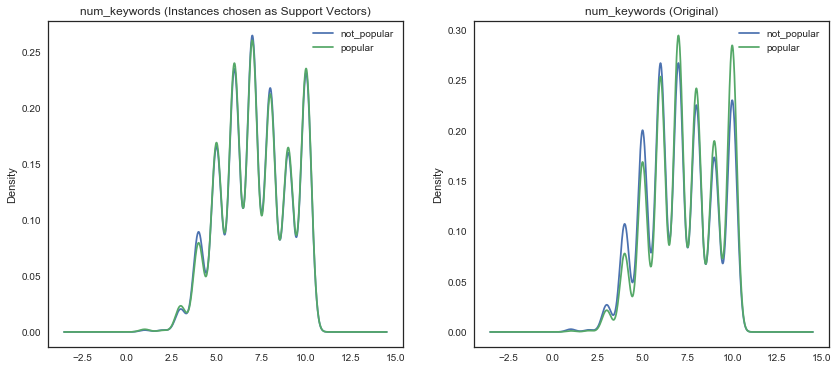

In [86]:
# now lets see the statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors

df_grouped_support = df_support.groupby(['popular'])
df_grouped = df_svm_top39.groupby(['popular'])

# plot KDE of Different variables

vars_to_plot = ['ln_kw_avg_avg', 
    'LDA_00',
    'LDA_01',
    'LDA_02',
    'LDA_03',
    'LDA_04',
    'data_channel_is_entertainment',
    'data_channel_is_socmed',
    'is_weekend',
    'kw_max_max',
    'ln_kw_min_max',
    'ln_num_imgs',
    'ln_num_videos',
    'global_subjectivity',
    'rate_positive_words',
    'ln_min_positive_polarity',
    'ln_global_rate_negative_words',
    'ln_self_reference_avg_sharess',
    'num_keywords'
]

for v in vars_to_plot:
    plt.figure(figsize=(14, 6))
    
    # plot support vector stats
    
    plt.subplot(1, 2, 1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['not_popular','popular'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['not_popular','popular'])
    plt.title(v+' (Original)')



So the analysis here is basically telling us what the original statistics of the data looked like, and also what the statistics of the support vectors looked like. We can see that the separation in distributions is not as great as the separation for the original data. This is because the support vectors tend to be instances on the edge of the class boundaries and also instances that are classified incorrectly in the training data.
  
You can also look at joint plots of the data and see how relationships have changed. (Hint hint for the min-lab assignment--this would be a nice analysis of the support vectors.)  

That's mostly it for using these things! They are really nice analysis tools and provide human interpretable summaries of the data.   

In [87]:
import seaborn as sns; sns.set(style = "white", color_codes = True)


#g = sns.jointplot(x = df_grouped['LDA_03'], y = df_grouped_support['LDA_03'])

### SVM - Version 2


In [99]:

# ... select top20 weighted parameters from linear model
# ... use in non-linear kernal analyses for ?improved? accuracy
# ... first : repeat linear analysis to see if accuracy affected by down-select

cols_2_keep = ['popular',
 'ln_kw_avg_avg', 
    'LDA_00',
    'LDA_01',
    'LDA_02',
    'LDA_03',
    'LDA_04',
    'data_channel_is_entertainment',
    'data_channel_is_socmed',
    'is_weekend',
    'kw_max_max',
    'ln_kw_min_max',
    'ln_num_imgs',
    'ln_num_videos',
    'global_subjectivity',
    'rate_positive_words',
    'ln_min_positive_polarity',
    'ln_global_rate_negative_words',
    'ln_self_reference_avg_sharess',
    'num_keywords']

df_svm_top20 = df_svm[cols_2_keep].copy()


In [100]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  separate X and y matrices 
# ...
# ...  convert to numpy matrices by calling 'values' on the pandas data frames
# ...  they are now simple matrices for compatibility with scikit-learn
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

if 'popular' in df_svm_top20:
    y = df_svm_top20['popular'].values         # set 'popular' as dependent
    del df_svm_top20['popular']                # remove from dataset
    X = df_svm_top20.values                    # use everything else for independent EVs

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  setup cross-validation in sklearn
# ...
# ...  split into training and test sets
# ....  --> 3 folds
# ...   --> 80% / 20% training / test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

num_cv_iterations = 3

num_instances = len(y)

cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [103]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  run through the cross validation loop and set the training and testing
# ...  variable for one single iteration
# ...
# ...  --> this method is memory-user, but easier to follow what is being done 
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

for train_indices, test_indices in cv_object.split(X, y): 
    X_train = X[train_indices]
    y_train = y[train_indices]    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... scale attributes by the training set
# ... - normalize features based on mean & stdev of each column
# ... - do not use the testing data
# ... - use what was last stored in the variables: X_train, y_train, X_test, y_test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

    scl_obj = StandardScaler()
    scl_obj.fit(X_train)                        # scale for each column for (0,1) mean, std
    
    X_train_scaled = scl_obj.transform(X_train) # apply to training
    X_test_scaled = scl_obj.transform(X_test) 

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... use SVM, train the model
# ...
# ... - C = 0.5
# ...   - penalty parameter; controls the trade-off between smooth decision boundary
# ...   - and classifying the training points correctly
# ...
# ... - kernel = linear
# ...
# ... - gamma = auto
# ...   - kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’;
# ...   - the higher the value of gamma, will try to exact fit
# ...   - for the rbf kernel the transformed space is infinite-dimensional
# ...
# ...  https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

C_param = 0.5

for ikrnl in ['rbf', 'poly', 'sigmoid']:
    
    C_param = C_param * 2
    tic = time.clock()

# ...  get SVC object

    krnl = ikrnl
    gamma_param = 'auto'

    svm_clf = SVC(C = C_param, kernel = krnl, degree = 3, gamma = gamma_param)

# ... train

    svm_clf.fit(X_train_scaled, y_train)

# ... print out process time

    toc = time.clock()
    print('\n----------------------------------------------------')
    print('Process time : ', toc - tic, 'seconds')
    print('----------------------------------------------------')

# ... test set predictions

    y_hat = svm_clf.predict(X_test_scaled)

# ... model classification metrics

    acc = mt.accuracy_score(y_test, y_hat)
    rec = mt.recall_score(y_test, y_hat)
    pre = mt.precision_score(y_test, y_hat)
    f1s = mt.f1_score(y_test, y_hat)

    conf = mt.confusion_matrix(y_test, y_hat)

    print('\n----------------------------------------------------')
    print('Model Accuracy = ', acc )
    print('Model Recall = ', rec )
    print('Model Precision = ', pre )
    print('Model F1 Score = ', f1s )

    print('\n----------------------------------------------------')
    print('Confusion matrix\n', conf)
    print('----------------------------------------------------')


# ... add model metrics to results data frame

    new_row = [krnl, C_param, gamma_param, len(df_svm_top20.columns), toc-tic, acc, rec, pre, f1s]
    df_results.loc[len(df_results)] = new_row

print(df_results)



----------------------------------------------------
Process time :  117.94742600000018 seconds
----------------------------------------------------

----------------------------------------------------
Model Accuracy =  0.645100264851
Model Recall =  0.652978453739
Model Precision =  0.640636657548
Model F1 Score =  0.646748681898

----------------------------------------------------
Confusion matrix
 [[2539 1445]
 [1369 2576]]
----------------------------------------------------

----------------------------------------------------
Process time :  173.09606200000007 seconds
----------------------------------------------------

----------------------------------------------------
Model Accuracy =  0.644721906924
Model Recall =  0.652724968314
Model Precision =  0.640228741919
Model F1 Score =  0.64641646793

----------------------------------------------------
Confusion matrix
 [[2537 1447]
 [1370 2575]]
----------------------------------------------------

--------------------------

#### Same accuracy with 20 down selected features as above with 39 features  

Re-run analysis with 20 features and non-linear kernel  
kernel = __rbf__  


In [91]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... use SVM, train the model
# ...
# ... - C = 0.5
# ...   - penalty parameter; controls the trade-off between smooth decision boundary
# ...   - and classifying the training points correctly
# ...
# ... - kernel = rbf
# ...
# ... - gamma = auto
# ...   - kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’;
# ...   - the higher the value of gamma, will try to exact fit
# ...   - for the rbf kernel the transformed space is infinite-dimensional
# ...
# ...  https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

tic = time.clock()

# ...  get SVC object

krnl = 'rbf'
C_param = 0.5
gamma_param = 'auto'

svm_clf = SVC(C = 0.5, kernel = 'rbf', degree = 3, gamma = 'auto')

# ... train

svm_clf.fit(X_train_scaled, y_train)

# ... print out process time

toc = time.clock()
print('\n----------------------------------------------------')
print('Process time : ', toc - tic, 'seconds')
print('----------------------------------------------------')

# ... test set predictions

y_hat = svm_clf.predict(X_test_scaled)

# ... model classification metrics

acc = mt.accuracy_score(y_test, y_hat)
rec = mt.recall_score(y_test, y_hat)
pre = mt.precision_score(y_test, y_hat)
f1s = mt.f1_score(y_test, y_hat)

conf = mt.confusion_matrix(y_test, y_hat)

print('\n----------------------------------------------------')
print('Model Accuracy = ', acc )
print('Model Recall = ', rec )
print('Model Precision = ', pre )
print('Model F1 Score = ', f1s )

print('\n----------------------------------------------------')
print('Confusion matrix\n', conf)
print('----------------------------------------------------')


# ... add model metrics to results data frame

new_row = [krnl, C_param, gamma_param, len(df_svm_top20.columns), toc-tic, acc, rec, pre, f1s]
df_results.loc[len(df_results)] = new_row
print(df_results)



----------------------------------------------------
Process time :  101.45315299999993 seconds
----------------------------------------------------

----------------------------------------------------
Model Accuracy =  0.656072644722
Model Recall =  0.65477412731
Model Precision =  0.648614289347
Model F1 Score =  0.651679652574

----------------------------------------------------
Confusion matrix
 [[2651 1382]
 [1345 2551]]
----------------------------------------------------
   kernel    C gamma n_features  process_time  accuracy    recall  precision  \
0  linear  0.5  auto         39    260.070015  0.642830  0.645990   0.629012   
1  linear  0.5  auto         19     82.815416  0.651154  0.662218   0.640199   
2     rbf  0.5  auto         19    101.453153  0.656073  0.654774   0.648614   

   f1_score  
0  0.637388  
1  0.651022  
2  0.651680  


In [92]:
# ... select Top10 ... and repeat

cols_2_keep = ['popular',
    'ln_kw_avg_avg',
    'kw_max_max',
    'LDA_00',
    'LDA_01',
    'LDA_02',
    'LDA_03',
    'LDA_04',
    'data_channel_is_entertainment',
    'data_channel_is_socmed',
    'is_weekend']

df_svm_top10 = df_svm[cols_2_keep].copy()


# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  separate X and y matrices 
# ...
# ...  convert to numpy matrices by calling 'values' on the pandas data frames
# ...  they are now simple matrices for compatibility with scikit-learn
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

if 'popular' in df_svm_top10:
    y = df_svm_top10['popular'].values         # set 'popular' as dependent
    del df_svm_top10['popular']                # remove from dataset
    X = df_svm_top10.values                    # use everything else for independent EVs

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  setup cross-validation in sklearn
# ...
# ...  split into training and test sets
# ....  --> 3 folds
# ...   --> 80% / 20% training / test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

num_cv_iterations = 3

num_instances = len(y)

cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  run through the cross validation loop and set the training and testing
# ...  variable for one single iteration
# ...
# ...  --> this method is memory-user, but easier to follow what is being done 
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

for train_indices, test_indices in cv_object.split(X, y): 
    X_train = X[train_indices]
    y_train = y[train_indices]    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... scale attributes by the training set
# ... - normalize features based on mean & stdev of each column
# ... - do not use the testing data
# ... - use what was last stored in the variables: X_train, y_train, X_test, y_test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

    scl_obj = StandardScaler()
    scl_obj.fit(X_train)                        # scale for each column for (0,1) mean, std
    
    X_train_scaled = scl_obj.transform(X_train) # apply to training
    X_test_scaled = scl_obj.transform(X_test) 

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... use SVM, train the model
# ...
# ... - C = 0.5
# ...   - penalty parameter; controls the trade-off between smooth decision boundary
# ...   - and classifying the training points correctly
# ...
# ... - kernel = linear
# ...
# ... - gamma = auto
# ...   - kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’;
# ...   - the higher the value of gamma, will try to exact fit
# ...   - for the rbf kernel the transformed space is infinite-dimensional
# ...
# ...  https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

tic = time.clock()

# ...  get SVC object

krnl = 'linear'
C_param = 0.5
gamma_param = 'auto'

svm_clf = SVC(C = 0.5, kernel = 'linear', degree = 3, gamma = 'auto')

# ... train

svm_clf.fit(X_train_scaled, y_train)

# ... print out process time

toc = time.clock()
print('\n----------------------------------------------------')
print('Process time : ', toc - tic, 'seconds')
print('----------------------------------------------------')

# ... test set predictions

y_hat = svm_clf.predict(X_test_scaled)

# ... model classification metrics

acc = mt.accuracy_score(y_test, y_hat)
rec = mt.recall_score(y_test, y_hat)
pre = mt.precision_score(y_test, y_hat)
f1s = mt.f1_score(y_test, y_hat)

conf = mt.confusion_matrix(y_test, y_hat)

print('\n----------------------------------------------------')
print('Model Accuracy = ', acc )
print('Model Recall = ', rec )
print('Model Precision = ', pre )
print('Model F1 Score = ', f1s )

print('\n----------------------------------------------------')
print('Confusion matrix\n', conf)
print('----------------------------------------------------')


# ... add model metrics to results data frame

new_row = [krnl, C_param, gamma_param, len(df_svm_top10.columns), toc-tic, acc, rec, pre, f1s]
df_results.loc[len(df_results)] = new_row
print(df_results)


ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)

----------------------------------------------------
Process time :  48.97334099999989 seconds
----------------------------------------------------

----------------------------------------------------
Model Accuracy =  0.629713709169
Model Recall =  0.694632621157
Model Precision =  0.601805869074
Model F1 Score =  0.644895984519

----------------------------------------------------
Confusion matrix
 [[2327 1764]
 [1172 2666]]
----------------------------------------------------
   kernel    C gamma n_features  process_time  accuracy    recall  precision  \
0  linear  0.5  auto         39    260.070015  0.642830  0.645990   0.629012   
1  linear  0.5  auto         19     82.815416  0.651154  0.662218   0.640199   
2     rbf  0.5  auto         19    101.453153  0.656073  0.654774   0.648614   
3  linear  0.5  auto         10     48.973341  0.629714  0.694633   0.601806   

   f1_score  
0  0.637388  
1  0.6510

In [93]:
df_svm.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 40 columns):
popular                            39644 non-null bool
n_tokens_title                     39644 non-null int64
num_keywords                       39644 non-null int64
data_channel_is_lifestyle          39644 non-null int64
data_channel_is_entertainment      39644 non-null int64
data_channel_is_socmed             39644 non-null int64
kw_avg_min                         39644 non-null float64
kw_max_max                         39644 non-null float64
kw_avg_max                         39644 non-null float64
weekday_is_monday                  39644 non-null int64
weekday_is_tuesday                 39644 non-null int64
weekday_is_wednesday               39644 non-null int64
weekday_is_thursday                39644 non-null int64
weekday_is_friday                  39644 non-null int64
is_weekend                         39644 non-null int64
LDA_00                             39644 non-n

In [94]:
# ... select Top6 ... and repeat

cols_2_keep = ['popular',
            'ln_kw_avg_avg',
            'LDA_02',
            'LDA_03',
            'LDA_01',
            'LDA_00',
            'data_channel_is_entertainment']

df_svm_top6 = df_svm[cols_2_keep].copy()

df_svm_top6.info()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  separate X and y matrices 
# ...
# ...  convert to numpy matrices by calling 'values' on the pandas data frames
# ...  they are now simple matrices for compatibility with scikit-learn
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

if 'popular' in df_svm_top6:
    y = df_svm_top6['popular'].values         # set 'popular' as dependent
    del df_svm_top6['popular']                # remove from dataset
    X = df_svm_top6.values                    # use everything else for independent EVs

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  setup cross-validation in sklearn
# ...
# ...  split into training and test sets
# ....  --> 3 folds
# ...   --> 80% / 20% training / test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                         test_size  = 0.2)               
print(cv_object)

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  run through the cross validation loop and set the training and testing
# ...  variable for one single iteration
# ...
# ...  --> this method is memory-user, but easier to follow what is being done 
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

for train_indices, test_indices in cv_object.split(X, y): 
    X_train = X[train_indices]
    y_train = y[train_indices]    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... scale attributes by the training set
# ... - normalize features based on mean & stdev of each column
# ... - do not use the testing data
# ... - use what was last stored in the variables: X_train, y_train, X_test, y_test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

    scl_obj = StandardScaler()
    scl_obj.fit(X_train)                        # scale for each column for (0,1) mean, std
    
    X_train_scaled = scl_obj.transform(X_train) # apply to training
    X_test_scaled = scl_obj.transform(X_test) 

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... use SVM, train the model
# ...
# ... - C = 0.5
# ...   - penalty parameter; controls the trade-off between smooth decision boundary
# ...   - and classifying the training points correctly
# ...
# ... - kernel = linear
# ...
# ... - gamma = auto
# ...   - kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’;
# ...   - the higher the value of gamma, will try to exact fit
# ...   - for the rbf kernel the transformed space is infinite-dimensional
# ...
# ...  https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

tic = time.clock()

# ...  get SVC object

krnl = 'linear'
C_param = 0.5
gamma_param = 'auto'

svm_clf = SVC(C = 0.5, kernel = 'linear', degree = 3, gamma = 'auto')

# ... train

svm_clf.fit(X_train_scaled, y_train)

# ... print out process time

toc = time.clock()
print('\n----------------------------------------------------')
print('Process time : ', toc - tic, 'seconds')
print('----------------------------------------------------')

# ... test set predictions

y_hat = svm_clf.predict(X_test_scaled)

# ... model classification metrics

acc = mt.accuracy_score(y_test, y_hat)
rec = mt.recall_score(y_test, y_hat)
pre = mt.precision_score(y_test, y_hat)
f1s = mt.f1_score(y_test, y_hat)

conf = mt.confusion_matrix(y_test, y_hat)

print('\n----------------------------------------------------')
print('Model Accuracy = ', acc )
print('Model Recall = ', rec )
print('Model Precision = ', pre )
print('Model F1 Score = ', f1s )

print('\n----------------------------------------------------')
print('Confusion matrix\n', conf)
print('----------------------------------------------------')


# ... add model metrics to results data frame

new_row = [krnl, C_param, gamma_param, len(df_svm_top6.columns), toc-tic, acc, rec, pre, f1s]
df_results.loc[len(df_results)] = new_row
print(df_results)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 7 columns):
popular                          39644 non-null bool
ln_kw_avg_avg                    39644 non-null float64
LDA_02                           39644 non-null float64
LDA_03                           39644 non-null float64
LDA_01                           39644 non-null float64
LDA_00                           39644 non-null float64
data_channel_is_entertainment    39644 non-null int64
dtypes: bool(1), float64(5), int64(1)
memory usage: 1.9 MB
ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)

----------------------------------------------------
Process time :  35.4967529999999 seconds
----------------------------------------------------

----------------------------------------------------
Model Accuracy =  0.59515701854
Model Recall =  0.698623151453
Model Precision =  0.57466442953
Model F1 Score =  0.630609896433

--------------------------------------

In [95]:
df_svm_top6.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 6 columns):
ln_kw_avg_avg                    39644 non-null float64
LDA_02                           39644 non-null float64
LDA_03                           39644 non-null float64
LDA_01                           39644 non-null float64
LDA_00                           39644 non-null float64
data_channel_is_entertainment    39644 non-null int64
dtypes: float64(5), int64(1)
memory usage: 1.8 MB


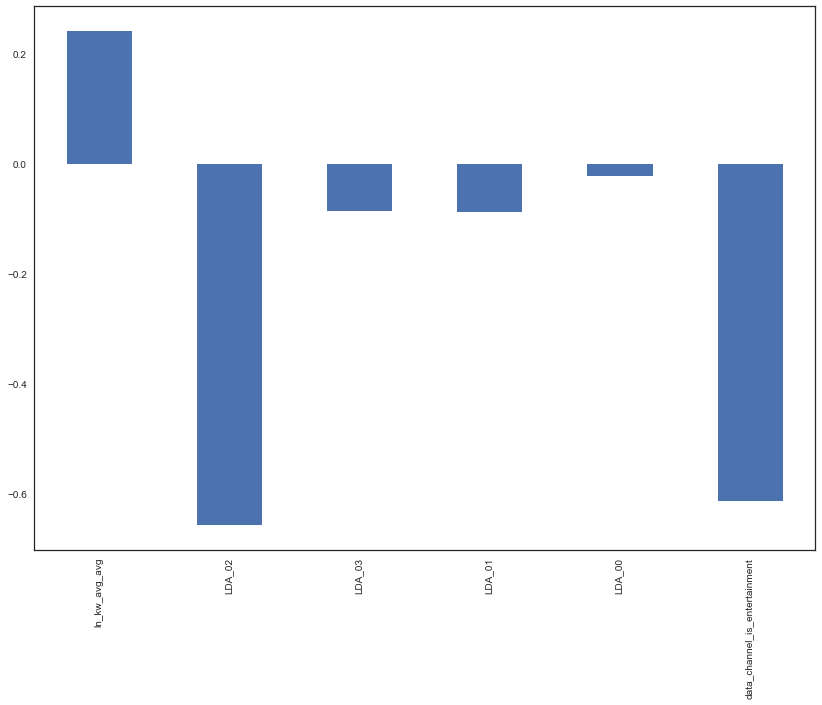

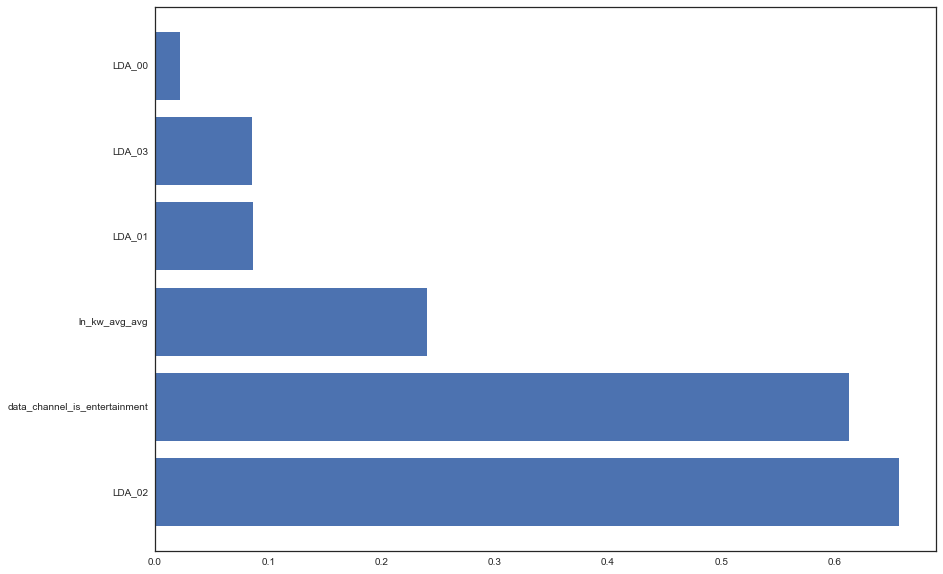

                                  LDA_02 :     0.657
           data_channel_is_entertainment :     0.613
                           ln_kw_avg_avg :     0.241
                                  LDA_01 :     0.087
                                  LDA_03 :     0.086
                                  LDA_00 :     0.023


In [96]:
def f_importances(coef, names):
    imp = coef
    imp_abs = abs(coef)
    imp, names = zip(*sorted(zip(imp_abs,names), reverse = True))
    plt.figure(figsize = (14,10))
    plt.barh(range(len(names)), imp, align = 'center')
    plt.yticks(range(len(names)), names)
    plt.show()
    for nm, val in zip(names, imp):
        print ("%40s : %9.3f" % (nm, val))

        
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  if kernel = linear -- can plot out the weights to evaluate relative influences
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

krnl = 'linear'

if krnl == 'linear':
#    print(svm_clf.coef_)
#    print(df_svm.columns)

# ... - vertical bar chart with sign retained to see +/- effects

    weights = pd.Series(svm_clf.coef_[0], index = df_svm_top6.columns)
    plt.figure(figsize=(14,10))
    weights.plot(kind = 'bar')

# ... - horizontal bar chart of abs value in ranked order

    f_importances(svm_clf.coef_[0], df_svm_top6.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 3 columns):
popular                          39644 non-null bool
LDA_02                           39644 non-null float64
data_channel_is_entertainment    39644 non-null int64
dtypes: bool(1), float64(1), int64(1)
memory usage: 658.2 KB
ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)

----------------------------------------------------
Process time :  24.620742000000064 seconds
----------------------------------------------------

----------------------------------------------------
Model Accuracy =  0.601715222601
Model Recall =  0.712760549059
Model Precision =  0.580298013245
Model F1 Score =  0.63974446726

----------------------------------------------------
Confusion matrix
 [[1967 2028]
 [1130 2804]]
----------------------------------------------------

----------------------------------------------------
Process time :  25.04032099999995 seconds
----------

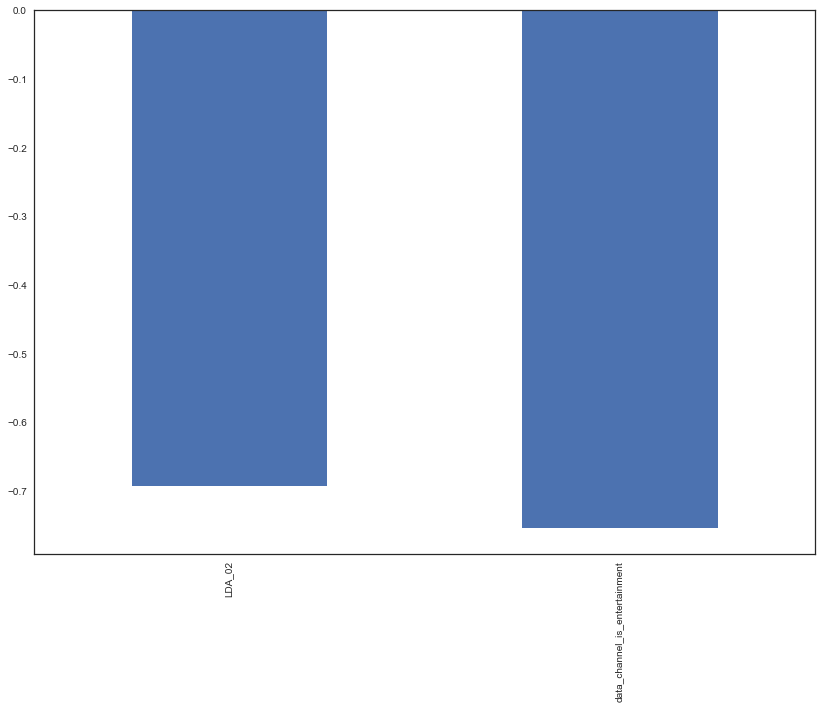

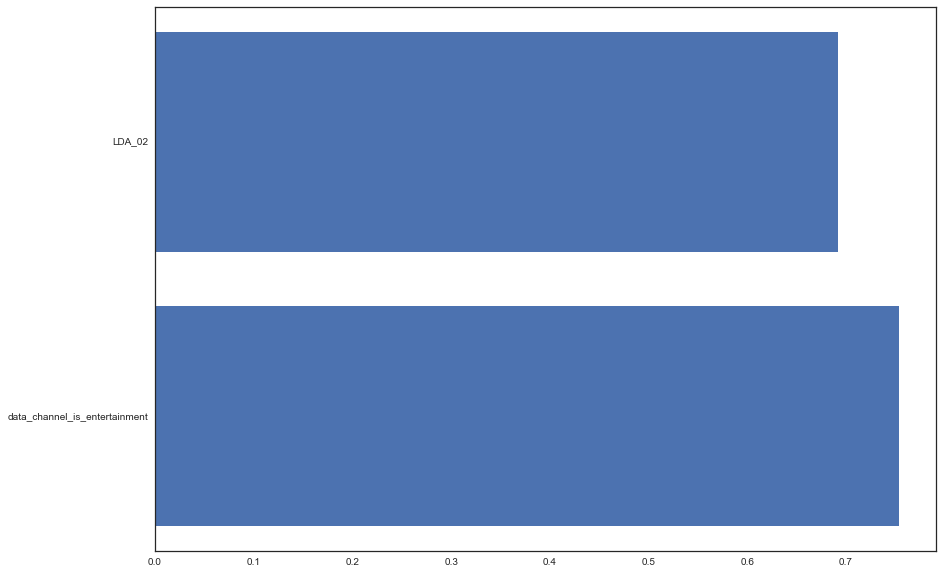

           data_channel_is_entertainment :     0.754
                                  LDA_02 :     0.692


In [97]:
# ... select Top2 ... and repeat

cols_2_keep = ['popular',
            'LDA_02',
            'data_channel_is_entertainment']

df_svm_top2 = df_svm[cols_2_keep].copy()

df_svm_top2.info()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  separate X and y matrices 
# ...
# ...  convert to numpy matrices by calling 'values' on the pandas data frames
# ...  they are now simple matrices for compatibility with scikit-learn
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

if 'popular' in df_svm_top2:
    y = df_svm_top2['popular'].values         # set 'popular' as dependent
    del df_svm_top2['popular']                # remove from dataset
    X = df_svm_top2.values                    # use everything else for independent EVs

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  setup cross-validation in sklearn
# ...
# ...  split into training and test sets
# ....  --> 3 folds
# ...   --> 80% / 20% training / test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                         test_size  = 0.2)               
print(cv_object)

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  run through the cross validation loop and set the training and testing
# ...  variable for one single iteration
# ...
# ...  --> this method is memory-user, but easier to follow what is being done 
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

for train_indices, test_indices in cv_object.split(X, y): 
    X_train = X[train_indices]
    y_train = y[train_indices]    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... scale attributes by the training set
# ... - normalize features based on mean & stdev of each column
# ... - do not use the testing data
# ... - use what was last stored in the variables: X_train, y_train, X_test, y_test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

    scl_obj = StandardScaler()
    scl_obj.fit(X_train)                        # scale for each column for (0,1) mean, std
    
    X_train_scaled = scl_obj.transform(X_train) # apply to training
    X_test_scaled = scl_obj.transform(X_test) 

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... use SVM, train the model
# ...
# ... - C = 0.5
# ...   - penalty parameter; controls the trade-off between smooth decision boundary
# ...   - and classifying the training points correctly
# ...
# ... - kernel = linear
# ...
# ... - gamma = auto
# ...   - kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’;
# ...   - the higher the value of gamma, will try to exact fit
# ...   - for the rbf kernel the transformed space is infinite-dimensional
# ...
# ...  https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

    tic = time.clock()

# ...  get SVC object

    krnl = 'linear'
    C_param = 0.5
    gamma_param = 'auto'
    
    svm_clf = SVC(C = 0.5, kernel = 'linear', degree = 3, gamma = 'auto')

# ... train

    svm_clf.fit(X_train_scaled, y_train)

# ... print out process time

    toc = time.clock()
    print('\n----------------------------------------------------')
    print('Process time : ', toc - tic, 'seconds')
    print('----------------------------------------------------')

# ... test set predictions

    y_hat = svm_clf.predict(X_test_scaled)

# ... model classification metrics

    acc = mt.accuracy_score(y_test, y_hat)
    rec = mt.recall_score(y_test, y_hat)
    pre = mt.precision_score(y_test, y_hat)
    f1s = mt.f1_score(y_test, y_hat)

    conf = mt.confusion_matrix(y_test, y_hat)

    print('\n----------------------------------------------------')
    print('Model Accuracy = ', acc )
    print('Model Recall = ', rec )
    print('Model Precision = ', pre )
    print('Model F1 Score = ', f1s )

    print('\n----------------------------------------------------')
    print('Confusion matrix\n', conf)
    print('----------------------------------------------------')

# ... add model metrics to results data frame

    new_row = [krnl, C_param, gamma_param, len(df_svm_top2.columns), toc-tic, acc, rec, pre, f1s]
    df_results.loc[len(df_results)] = new_row

print(df_results)
  
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  if kernel = linear -- can plot out the weights to evaluate relative influences
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

krnl = 'linear'

if krnl == 'linear':
#    print(svm_clf.coef_)
#    print(df_svm.columns)

# ... - vertical bar chart with sign retained to see +/- effects

    weights = pd.Series(svm_clf.coef_[0], index = df_svm_top2.columns)
    plt.figure(figsize=(14,10))
    weights.plot(kind = 'bar')

# ... - horizontal bar chart of abs value in ranked order

    f_importances(svm_clf.coef_[0], df_svm_top2.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 2 columns):
popular                          39644 non-null bool
data_channel_is_entertainment    39644 non-null int64
dtypes: bool(1), int64(1)
memory usage: 348.5 KB
ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


/home/mcdevitt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



----------------------------------------------------
Process time :  14.85365499999989 seconds
----------------------------------------------------

----------------------------------------------------
Model Accuracy =  0.54508765292
Model Recall =  0.866107723577
Model Precision =  0.525350593312
Model F1 Score =  0.654004796163

----------------------------------------------------
Confusion matrix
 [[ 913 3080]
 [ 527 3409]]
----------------------------------------------------

----------------------------------------------------
Process time :  15.008809999999812 seconds
----------------------------------------------------

----------------------------------------------------
Model Accuracy =  0.536385420608
Model Recall =  0.870260510704
Model Precision =  0.515350542233
Model F1 Score =  0.647352264006

----------------------------------------------------
Confusion matrix
 [[ 879 3173]
 [ 503 3374]]
----------------------------------------------------

---------------------------

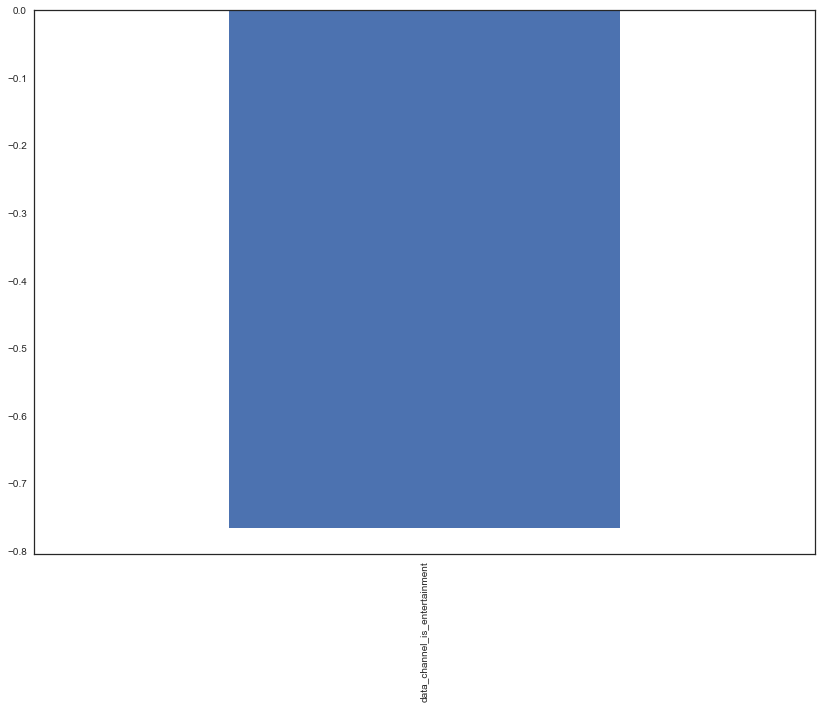

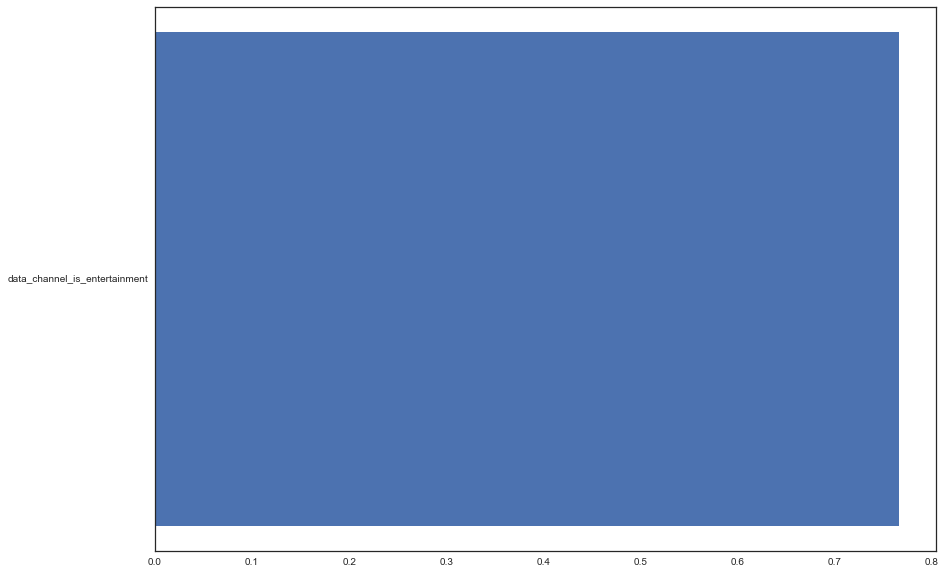

           data_channel_is_entertainment :     0.766


In [98]:
# ... select Top1 ... and repeat

cols_2_keep = ['popular',
            'data_channel_is_entertainment']

df_svm_top1 = df_svm[cols_2_keep].copy()

df_svm_top1.info()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  separate X and y matrices 
# ...
# ...  convert to numpy matrices by calling 'values' on the pandas data frames
# ...  they are now simple matrices for compatibility with scikit-learn
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

if 'popular' in df_svm_top1:
    y = df_svm_top1['popular'].values         # set 'popular' as dependent
    del df_svm_top1['popular']                # remove from dataset
    X = df_svm_top1.values                    # use everything else for independent EVs

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  setup cross-validation in sklearn
# ...
# ...  split into training and test sets
# ....  --> 3 folds
# ...   --> 80% / 20% training / test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                         test_size  = 0.2)               
print(cv_object)

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  run through the cross validation loop and set the training and testing
# ...  variable for one single iteration
# ...
# ...  --> this method is memory-user, but easier to follow what is being done 
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

for train_indices, test_indices in cv_object.split(X, y): 
    X_train = X[train_indices]
    y_train = y[train_indices]    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... scale attributes by the training set
# ... - normalize features based on mean & stdev of each column
# ... - do not use the testing data
# ... - use what was last stored in the variables: X_train, y_train, X_test, y_test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

    scl_obj = StandardScaler()
    scl_obj.fit(X_train)                        # scale for each column for (0,1) mean, std
    
    X_train_scaled = scl_obj.transform(X_train) # apply to training
    X_test_scaled = scl_obj.transform(X_test) 

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... use SVM, train the model
# ...
# ... - C = 0.5
# ...   - penalty parameter; controls the trade-off between smooth decision boundary
# ...   - and classifying the training points correctly
# ...
# ... - kernel = linear
# ...
# ... - gamma = auto
# ...   - kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’;
# ...   - the higher the value of gamma, will try to exact fit
# ...   - for the rbf kernel the transformed space is infinite-dimensional
# ...
# ...  https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

    tic = time.clock()

# ...  get SVC object

    krnl = 'linear'
    C_param = 0.5
    gamma_param = 'auto'

    svm_clf = SVC(C = C_param, kernel = krnl, degree = 3, gamma = gamma_param)

# ... train

    svm_clf.fit(X_train_scaled, y_train)

# ... print out process time

    toc = time.clock()
    print('\n----------------------------------------------------')
    print('Process time : ', toc - tic, 'seconds')
    print('----------------------------------------------------')

# ... test set predictions

    y_hat = svm_clf.predict(X_test_scaled)

# ... model classification metrics

    acc = mt.accuracy_score(y_test, y_hat)
    rec = mt.recall_score(y_test, y_hat)
    pre = mt.precision_score(y_test, y_hat)
    f1s = mt.f1_score(y_test, y_hat)

    conf = mt.confusion_matrix(y_test, y_hat)

    print('\n----------------------------------------------------')
    print('Model Accuracy = ', acc )
    print('Model Recall = ', rec )
    print('Model Precision = ', pre )
    print('Model F1 Score = ', f1s )

    print('\n----------------------------------------------------')
    print('Confusion matrix\n', conf)
    print('----------------------------------------------------')

    new_row = [krnl, C_param, gamma_param, len(df_svm_top1.columns), toc-tic, acc, rec, pre, f1s]
    df_results.loc[len(df_results)] = new_row

print(df_results)

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  if kernel = linear -- can plot out the weights to evaluate relative influences
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

krnl = 'linear'

if krnl == 'linear':
#    print(svm_clf.coef_)
#    print(df_svm.columns)

# ... - vertical bar chart with sign retained to see +/- effects

    weights = pd.Series(svm_clf.coef_[0], index = df_svm_top1.columns)
    plt.figure(figsize=(14,10))
    weights.plot(kind = 'bar')

# ... - horizontal bar chart of abs value in ranked order

    f_importances(svm_clf.coef_[0], df_svm_top1.columns)

In [106]:

print(df_results.round(3))

    kernel     C gamma n_features  process_time  accuracy  recall  precision  \
0   linear   0.5  auto         39       260.070     0.643   0.646      0.629   
1   linear   0.5  auto         19        82.815     0.651   0.662      0.640   
2      rbf   0.5  auto         19       101.453     0.656   0.655      0.649   
3   linear   0.5  auto         10        48.973     0.630   0.695      0.602   
4   linear   0.5  auto          6        35.497     0.595   0.699      0.575   
5   linear   0.5  auto          2        24.621     0.602   0.713      0.580   
6   linear   0.5  auto          2        25.040     0.603   0.719      0.582   
7   linear   0.5  auto          2        24.783     0.594   0.721      0.562   
8   linear   0.5  auto          1        14.854     0.545   0.866      0.525   
9   linear   0.5  auto          1        15.009     0.536   0.870      0.515   
10  linear   0.5  auto          1        14.814     0.539   0.867      0.520   
11  linear   1.0  auto         19       

# Create Model: 
## b. Logistic Regression:
For our logistic models we are running 5 models with different parameter.

#### 1. simple logistic with default values
#### 2. L2 penalty with C value of 0.05
#### 3. L1 penalty with C value of 0.05
#### 4. L2 penalty with C value of 1.00
#### 5. L1 penalty with C value of 1.00

Each model will be weighed agaist Accuracy, Precision, Recall and Fscore.

In [1]:
comparison_tbl = pd.DataFrame(columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing time'])
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix as conf
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from tabulate import tabulate

NameError: name 'pd' is not defined

In [ ]:
lr_model1 = LogisticRegression()
lr_model2 = LogisticRegression(penalty='l2', C=0.05)
lr_model3 = LogisticRegression(penalty='l1', C=0.05)
lr_model4 = LogisticRegression(penalty='l2', C=100.00)
lr_model5 = LogisticRegression(penalty='l1', C=100.00)
i_index=[]
i_index = 0
# ###################################### LR model 1 ##########################

tic = time.clock()
lr_model1.fit(X_train_scaled, y_train)  # train object
y_hat = lr_model1.predict(X_test_scaled) # get test set precitions
print("====model 1 ====")
accuracy = '{0:.4f}'.format(mt.accuracy_score(y_test, y_hat))
recall = '{0:.4f}'.format(mt.recall_score(y_test, y_hat))
precision = '{0:.4f}'.format(mt.precision_score(y_test, y_hat))
fscore = '{0:.4f}'.format(mt.f1_score(y_test, y_hat))
print("accuracy",accuracy )
print("confusion matrix\n", conf(y_test, y_hat))
print('precision:',precision)
print('recall:',recall)
print('fscore:',fscore)
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)
print('process time',exetime)
print("\n")

raw_data = {
    'Model Name':'LR Model 1, Simple',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':fscore,
    'Processing time': exetime
}

df = pd.DataFrame(raw_data,columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing time'],index=[i_index+1])
comparison_tbl = comparison_tbl.append(df)

# ###################################### LR model 2 ##########################
tic = time.clock()
lr_model2.fit(X_train_scaled, y_train)  # train object
y_hat = lr_model2.predict(X_test_scaled) # get test set precitions

print("====model 2 ====")
accuracy = '{0:.4f}'.format(mt.accuracy_score(y_test, y_hat))
recall = '{0:.4f}'.format(mt.recall_score(y_test, y_hat))
precision = '{0:.4f}'.format(mt.precision_score(y_test, y_hat))
fscore = '{0:.4f}'.format(mt.f1_score(y_test, y_hat))
print("accuracy",accuracy )
print("confusion matrix\n", conf(y_test, y_hat))
print('precision:',precision)
print('recall:',recall)
print('fscore:',fscore)
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)
print('process time',exetime)
print("\n")

raw_data = {
    'Model Name':'LR Model 2,Penalty L2, c 0.05',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':fscore,
    'Processing time': exetime
}

df = pd.DataFrame(raw_data,columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing time'],index=[i_index+1])
comparison_tbl = comparison_tbl.append(df)
# ###################################### LR model 3 ##########################
tic = time.clock()
lr_model3.fit(X_train_scaled, y_train)  # train object
y_hat = lr_model3.predict(X_test_scaled) # get test set precitions

print("====model 3 ====")
accuracy = '{0:.4f}'.format(mt.accuracy_score(y_test, y_hat))
recall = '{0:.4f}'.format(mt.recall_score(y_test, y_hat))
precision = '{0:.4f}'.format(mt.precision_score(y_test, y_hat))
fscore = '{0:.4f}'.format(mt.f1_score(y_test, y_hat))
print("accuracy",accuracy )
print("confusion matrix\n", conf(y_test, y_hat))
print('precision:',precision)
print('recall:',recall)
print('fscore:',fscore)
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)
print('process time',exetime)
print("\n")

raw_data = {
    'Model Name':'LR Model 3,Penalty L1, c 0.05',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':fscore,
    'Processing time': exetime
}

df = pd.DataFrame(raw_data,columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing time'],index=[i_index+1])
comparison_tbl = comparison_tbl.append(df)

# ###################################### LR model 4 ##########################

tic = time.clock()
lr_model4.fit(X_train_scaled, y_train)  # train object
y_hat = lr_model4.predict(X_test_scaled) # get test set precitions

print("====model 4 ====")
accuracy = '{0:.4f}'.format(mt.accuracy_score(y_test, y_hat))
recall = '{0:.4f}'.format(mt.recall_score(y_test, y_hat))
precision = '{0:.4f}'.format(mt.precision_score(y_test, y_hat))
fscore = '{0:.4f}'.format(mt.f1_score(y_test, y_hat))
print("accuracy",accuracy )
print("confusion matrix\n", conf(y_test, y_hat))
print('precision:',precision)
print('recall:',recall)
print('fscore:',fscore)
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)
print('process time',exetime)
print("\n")

raw_data = {
    'Model Name':'LR Model 4,Penalty L1, c 100',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':fscore,
    'Processing time': exetime
}

df = pd.DataFrame(raw_data,columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing time'],index=[i_index+1])
comparison_tbl = comparison_tbl.append(df)

# ################################# LR model 5 #####################

tic = time.clock()
lr_model5.fit(X_train_scaled, y_train)  # train object
y_hat = lr_model5.predict(X_test_scaled) # get test set precitions

print("====model 5 ====")
accuracy = '{0:.4f}'.format(mt.accuracy_score(y_test, y_hat))
recall = '{0:.4f}'.format(mt.recall_score(y_test, y_hat))
precision = '{0:.4f}'.format(mt.precision_score(y_test, y_hat))
fscore = '{0:.4f}'.format(mt.f1_score(y_test, y_hat))
print("accuracy",accuracy )
print("confusion matrix\n", conf(y_test, y_hat))
print('precision:',precision)
print('recall:',recall)
print('fscore:',fscore)
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)
print('process time',exetime)
print("\n")

raw_data = {
    'Model Name':'LR Model 5,Penalty L2, c 100',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':fscore,
    'Processing time': exetime
}

df = pd.DataFrame(raw_data,columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing time'],index=[i_index+1])
comparison_tbl = comparison_tbl.append(df)

# Model Advantages PREETI TO DO THIS PART

Let's look at the summary of each model.

In [ ]:
comparison_tbl

In [ ]:
We have 5 LR models .. svm models

For LR, We can see that all the scores for each model is very negligible difference. Our choise for final model would be based on 2 factors, C value and Penalty.

smaller C value is, lower the freedom we are giving the model. a good model to choose.

With all the reasons above we choose model 3 to be our final LR model. We will look into co-efficients and variables further sections.

#### chosen LR model

In [ ]:
num_cv_iterations = 5
num_instances = len(y)
cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                         test_size  = 0.2)
cv_accuracy=[]
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_model3.fit(X_train, y_train)  # train object
    y_hat = lr_model3.predict(X_test) # get test set precitions
    print("====Iteration",iter_num," ====")
    print("accuracy", acc(y_test, y_hat) )
    print("confusion matrix\n", conf(y_test, y_hat))
    cv_accuracy.append(acc(y_test, y_hat))
    iter_num+=1

In [ ]:
sns.set(style="ticks")
sns.boxplot(y = cv_accuracy,palette="seismic" )
plt.xlabel('Classifier: Logistic Regression')
plt.ylabel('Accuracy')
plt.show()

# Interpret feature importance ANDREW TO DO 
Our final selected logistic regression model is model 3. Let's look further into the output of model 3.

In [ ]:
weights = pd.Series(lr_model3.coef_[0], index = df_svm.columns)
weights.sort_values(axis=0, ascending=True, inplace=True)
lr_df = pd.DataFrame(weights).reset_index()
lr_df.columns=['var','weights']
lr_df.weights = lr_df.weights.astype(float)
lr_df = lr_df[(lr_df.weights > 0.001) | (lr_df.weights < -0.001)]
lr_df.sort_values(['weights'],ascending=False,inplace=True)
print(tabulate(lr_df,headers=['Variable','Weights'],tablefmt="grid")) 

In [ ]:
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 8, 20
sns.barplot(data=lr_df,y='var',x='weights')
plt.xlabel('Weights')
plt.ylabel('Variables')
plt.show()

### Interpret Support Vectors PATRICK!!! TO DO